In [1]:
import cartopy

In [2]:
import xarray as xr
import sys
sys.path.insert(0,"/Users/auraoupa/lib/python")

import numpy as np
sys.path.insert(0,"/Users/auraoupa/Work/git/xscale")
import xscale
import xscale.spectral.fft as xfft
from matplotlib.colors import LogNorm
import cmocean
import matplotlib.pylab as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.cm as mplcm
seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

sys.path.insert(0,"/Users/auraoupa/lib/python/w_k_scripts")
import Wavenum_freq_spec_func as wfs

In [3]:
gridfile="/Users/auraoupa/Data/eNATL60/eNATL60-I/mesh_mask_eNATL60_3.6.nc"
dsgrid=xr.open_mfdataset(gridfile)
ff=dsgrid['ff']

In [4]:
## Dataset

dirtide="/Users/auraoupa/Data/eNATL60/eNATL60-BLBT02-S/1h/ACO/"
dirnotide="/Users/auraoupa/Data/eNATL60/eNATL60-BLB002-S/1h/ACO/"



In [5]:
filesUtide="eNATL60ACO-BLBT02_1h_*_gridU-2D_*.nc"
filesVtide="eNATL60ACO-BLBT02_1h_*_gridV-2D_*.nc"

tfilesUtide=dirtide+filesUtide
tfilesVtide=dirtide+filesVtide

filesUnotide="eNATL60ACO-BLB002_1h_*_gridU-2D_*.nc"
filesVnotide="eNATL60ACO-BLB002_1h_*_gridV-2D_*.nc"

tfilesUnotide=dirnotide+filesUnotide
tfilesVnotide=dirnotide+filesVnotide


In [6]:
fUtide = xr.open_mfdataset(tfilesUtide,chunks={'time_counter':744,'x':500,'y':500})
Utide=fUtide['sozocrtx'][:]
navlat= fUtide['nav_lat']
navlon= fUtide['nav_lon']

fUnotide = xr.open_mfdataset(tfilesUnotide)
Unotide=fUnotide['sozocrtx'][:]

fVtide = xr.open_mfdataset(tfilesVtide)
Vtide=fVtide['somecrty'][:]

fVnotide = xr.open_mfdataset(tfilesVnotide)
Vnotide=fVnotide['somecrty'][:]


In [7]:
Utide

<xarray.DataArray 'sozocrtx' (time_counter: 744, y: 1191, x: 781)>
dask.array<shape=(744, 1191, 781), dtype=float32, chunksize=(24, 500, 500)>
Coordinates:
    nav_lat        (y, x) float32 23.174568 23.174568 ... 40.094227 40.094173
    nav_lon        (y, x) float32 -37.391693 -37.375027 ... -24.363064
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(744,), chunksize=(24,)>
  * time_counter   (time_counter) datetime64[ns] 2009-07-10T00:30:00 ... 2009-08-09T23:30:00
Dimensions without coordinates: y, x
Attributes:
    long_name:           ocean surface current along i-axis
    units:               m/s
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)

In [8]:
T=2*np.pi/(1E-4)

In [9]:
print T

62831.8530718


In [10]:
box=(-31,-28,33,36)
domain=(box[0]<navlon)*(navlon<box[1])*(box[2]<navlat)*(navlat<box[3])
where=np.where(domain)

lats=navlat[where]
lons=navlon[where]


In [11]:

ind = np.unravel_index(np.argmin(lats, axis=None), lats.shape)
jmin = where[0][ind[0]]
ind = np.unravel_index(np.argmax(lats, axis=None), lats.shape)
jmax = where[0][ind[0]]
ind = np.unravel_index(np.argmin(lons, axis=None), lons.shape)
imin = where[1][ind[1]]
ind = np.unravel_index(np.argmax(lons, axis=None), lons.shape)
imax = where[1][ind[1]]


In [12]:
ii=(imin+imax)/2
jj=(jmin+jmax)/2

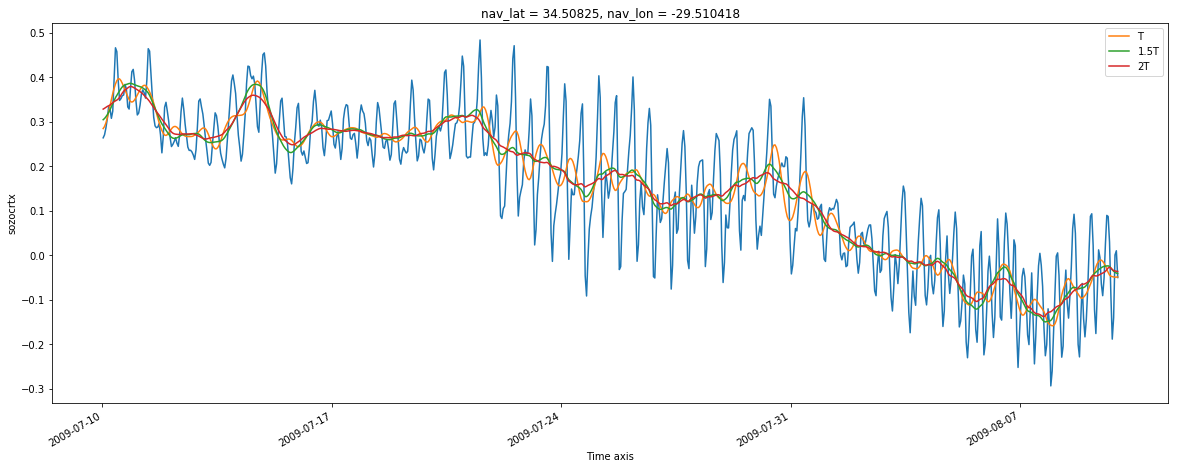

In [13]:
wutide1=Utide.window
wutide1.set(n=48,dim='time_counter', cutoff=T)
Utidefilt1=wutide1.convolve()

wutide3=Utide.window
wutide3.set(n=48,dim='time_counter', cutoff=1.5*T)
Utidefilt3=wutide3.convolve()

wutide5=Utide.window
wutide5.set(n=48,dim='time_counter', cutoff=2*T)
Utidefilt5=wutide5.convolve()

fig=plt.figure(figsize=(20,7))
Utide.isel(y=jj, x=ii).plot()
Utidefilt1.isel(y=jj, x=ii).plot(label='T')
Utidefilt3.isel(y=jj, x=ii).plot(label='1.5T')
Utidefilt5.isel(y=jj, x=ii).plot(label='2T')
plt.legend()

In [14]:
def plot_surf(sub,data,lon,lat,vmin,vmax,cmap,title,date):
    
    ax = plt.subplot(sub,projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent((-36, -26, 25, 40))
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor=cfeature.COLORS['land'])
    ax.add_feature(land)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.pcolormesh(lon,lat,data,cmap=cmap,vmin=vmin,vmax=vmax )
    plt.colorbar(orientation='horizontal',pad=0.1)
    plt.title(title)
    ax.text(0.57, -0.08, date, transform=ax.transAxes)

    ax.plot([-31, -28], [33, 33],color='black',linewidth=4)
    ax.plot([-31, -28], [36, 36],color='black',linewidth=4)
    ax.plot([-31, -31], [33, 36],color='black',linewidth=4)
    ax.plot([-28, -28], [33, 36],color='black',linewidth=4)


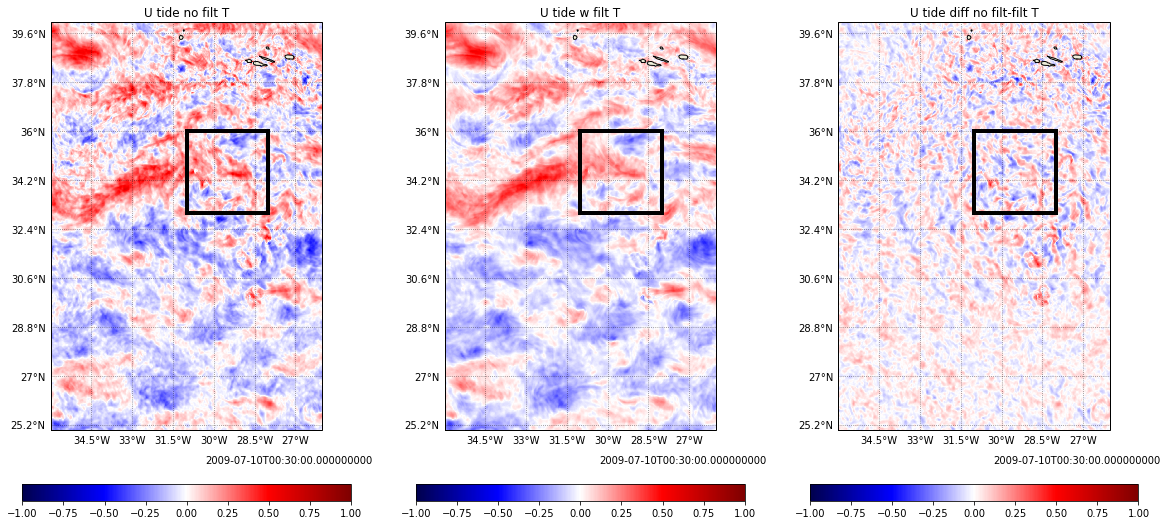

In [15]:
wutide1=Utide.window
wutide1.set(n=48,dim='time_counter', cutoff=T)
Utidefilt1=wutide1.convolve()

fig=plt.figure(figsize=(20,10))

plot_surf(131,Utide[0],navlon,navlat,-1,1,div_cmap,'U tide no filt T',str(Utide[0].time_counter.values))
plot_surf(132,Utidefilt1[0],navlon,navlat,-1,1,div_cmap,'U tide w filt T',str(Utide[0].time_counter.values))
plot_surf(133,Utide[0]-Utidefilt1[0],navlon,navlat,-1,1,div_cmap,'U tide diff no filt-filt T',str(Utide[0].time_counter.values))



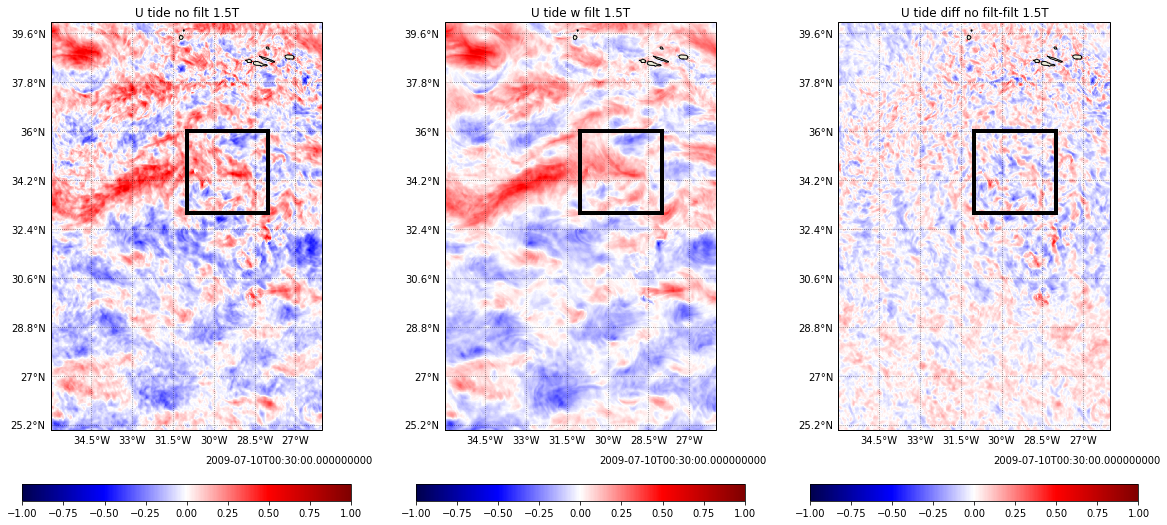

In [16]:
wutide3=Utide.window
wutide3.set(n=48,dim='time_counter', cutoff=1.5*T)
Utidefilt3=wutide3.convolve()
fig=plt.figure(figsize=(20,10))

plot_surf(131,Utide[0],navlon,navlat,-1,1,div_cmap,'U tide no filt 1.5T',str(Utide[0].time_counter.values))
plot_surf(132,Utidefilt3[0],navlon,navlat,-1,1,div_cmap,'U tide w filt 1.5T',str(Utide[0].time_counter.values))
plot_surf(133,Utide[0]-Utidefilt3[0],navlon,navlat,-1,1,div_cmap,'U tide diff no filt-filt 1.5T',str(Utide[0].time_counter.values))



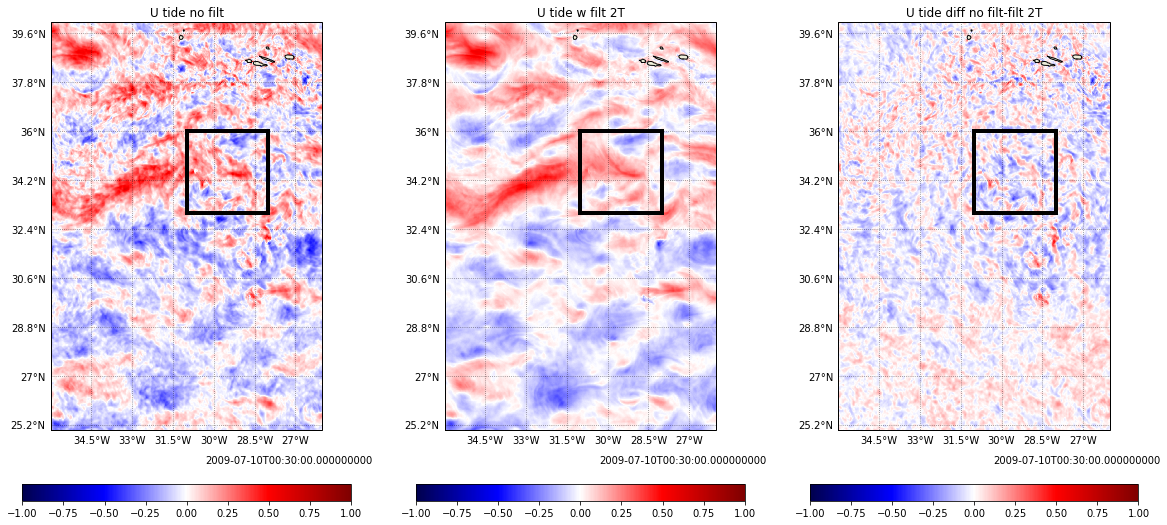

In [17]:
wutide5=Utide.window
wutide5.set(n=48,dim='time_counter', cutoff=2*T)
Utidefilt5=wutide5.convolve()

fig=plt.figure(figsize=(20,10))

plot_surf(131,Utide[0],navlon,navlat,-1,1,div_cmap,'U tide no filt',str(Utide[0].time_counter.values))
plot_surf(132,Utidefilt5[0],navlon,navlat,-1,1,div_cmap,'U tide w filt 2T',str(Utide[0].time_counter.values))
plot_surf(133,Utide[0]-Utidefilt5[0],navlon,navlat,-1,1,div_cmap,'U tide diff no filt-filt 2T',str(Utide[0].time_counter.values))


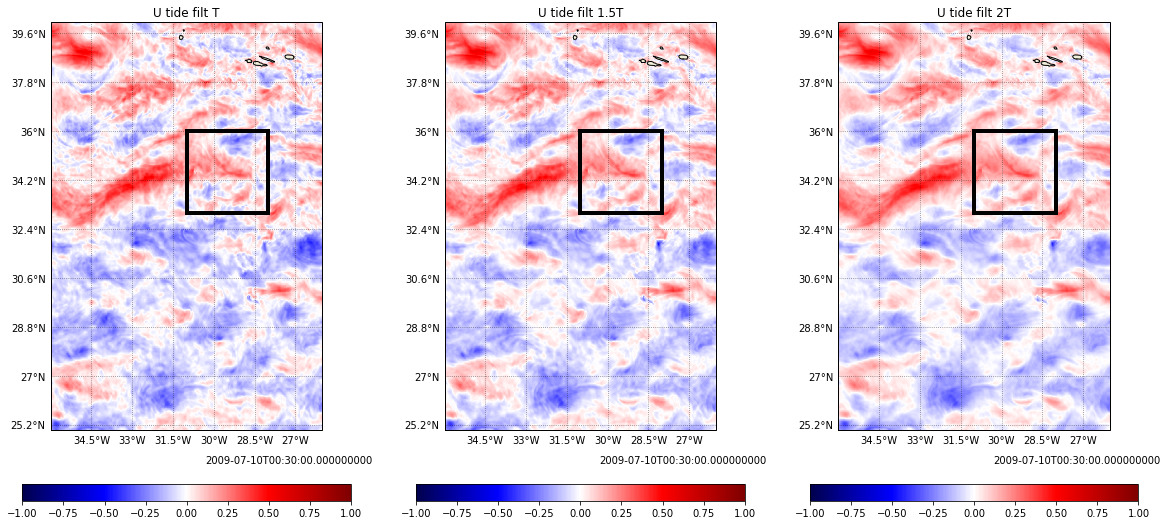

In [18]:
fig=plt.figure(figsize=(20,10))

plot_surf(131,Utidefilt1[0],navlon,navlat,-1,1,div_cmap,'U tide filt T',str(Utide[0].time_counter.values))
plot_surf(132,Utidefilt3[0],navlon,navlat,-1,1,div_cmap,'U tide filt 1.5T',str(Utide[0].time_counter.values))
plot_surf(133,Utidefilt5[0],navlon,navlat,-1,1,div_cmap,'U tide filt 2T',str(Utide[0].time_counter.values))
